<a href="https://www.kaggle.com/code/chickenugget/predicting-effective-argument-using-lst-model?scriptVersionId=102913356" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

### Load the dataset from kaggle's data directory.
Check the working directory of kaggle's dataset and load its train dataset.

In [1]:
import os
os.listdir('/kaggle/input/feedback-prize-effectiveness')

['sample_submission.csv', 'train.csv', 'test.csv', 'test', 'train']

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split


df_train = pd.read_csv("../input/feedback-prize-effectiveness/train.csv")
df_test = pd.read_csv('../input/feedback-prize-effectiveness/test.csv')
df_submission = pd.read_csv("../input/feedback-prize-effectiveness/sample_submission.csv")

df_train['discourse_text'].isnull().sum() # checks for NAs


0

### Data pre-processing

Remove stopwords from corpus stopwords dictionary to prevent commonly used language or text such as 'a', 'the', etc, that may affect the predictive performance.

In [3]:
import string
string.punctuation 
import re
from nltk.corpus import stopwords 
from collections import Counter
from itertools import chain

stop = set(stopwords.words('english')) 
print(stop)
df_train['discourse_text'].replace("[^a-zA-Z]"," ", regex=True, inplace =True)  # match strings that contains non-letter and replace with black to remove string.punctuations.
df_train['discourse_text'] = df_train['discourse_text'].str.lower() # converts strings to lower case.
print(df_train)
df_train['discourse_text'] = df_train['discourse_text'].apply(lambda x: [item for item in str(x).split() if item not in stop])
print(df_train['discourse_text'])
freq = pd.Series(Counter(chain.from_iterable(df_train['discourse_text']))).sort_values(ascending=False).reset_index() # count the frequencies of words.
print(freq)

{'more', 'didn', 'each', "couldn't", 'this', 'having', 'not', "aren't", "isn't", 've', 'for', "hadn't", "won't", 'a', 'when', 'hadn', 'won', 'him', 'by', 'do', 'few', 'but', 'further', 'against', 'isn', 'where', 'were', 'that', 'own', 'needn', 'after', 'only', 'any', "hasn't", 'too', 'our', 'he', 'will', 'o', 'hasn', 'i', 'are', 'under', 'shan', 'your', 'doesn', 'an', 'how', 'was', 'her', 'don', 'my', 'once', 'itself', 'its', 'did', 'she', 'they', 'over', "should've", 'off', 'themselves', 'yours', 'mustn', 'the', 'wasn', 'who', 'than', "weren't", 'and', 'm', 'here', 'couldn', 'it', 'we', 'yourselves', "didn't", 'doing', 'y', 'most', 'whom', 'am', 'myself', 'is', 'to', 'has', 'what', 't', 'both', 'until', 's', 'above', "don't", 'his', 'as', 'aren', 'wouldn', 'me', 'such', 'below', 'or', 'down', 'have', 'them', 'so', "you'd", 'those', 'with', 'ourselves', 'from', 'theirs', 'if', "mustn't", 'because', 'herself', 'before', 'been', "doesn't", 'same', "haven't", "it's", 'weren', 'haven', 'up

#### Note: To access and run nltk corpora 'owm-1.4' file without internet, simply download the file at https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/packages/corpora/omw-1.4.zip , upload to kaggle dataset and run the below command to install the file from kaggle input into the kernel.

In [4]:
!ln -s /kaggle/input/nltk-omw/omw-1.4 /usr/share/nltk_data/corpora/omw-1.4 

##### To test if the file is working:

In [5]:
import nltk
nltk.corpus.wordnet.synsets('think')

[Synset('think.n.01'),
 Synset('think.v.01'),
 Synset('think.v.02'),
 Synset('think.v.03'),
 Synset('remember.v.01'),
 Synset('think.v.05'),
 Synset('think.v.06'),
 Synset('intend.v.01'),
 Synset('think.v.08'),
 Synset('think.v.09'),
 Synset('think.v.10'),
 Synset('think.v.11'),
 Synset('think.v.12'),
 Synset('think.v.13')]

#### Lemmatize all tokens into a new list to prevent overfitting of dataset when verb, nouns, adverb or adjectives are not as concerning on the impact of effectiveness of an argument.


In [6]:
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk import word_tokenize
wordnet_lem = WordNetLemmatizer()
df_train['discourse_text'] = df_train['discourse_text'].apply(
                   lambda lst:[wordnet_lem.lemmatize(word, pos='v') for word in lst])
df_train['discourse_text'] = df_train['discourse_text'].apply(
                    lambda lst:[wordnet_lem.lemmatize(word, pos='n') for word in lst])
df_train['discourse_text'] = df_train['discourse_text'].apply(
                    lambda lst:[wordnet_lem.lemmatize(word, pos='r') for word in lst])
df_train['discourse_text'] = df_train['discourse_text'].apply(
                    lambda lst:[wordnet_lem.lemmatize(word, pos='a') for word in lst])
freq_final = pd.Series(Counter(chain.from_iterable(df_train['discourse_text']))).sort_values(ascending=False)
print(freq_final)


student        16402
people         10878
would          10700
vote           10621
school          8926
               ...  
activtys           1
adaped             1
intertaning        1
teatchers          1
protrude           1
Length: 21751, dtype: int64


##### Check the number of repeating words.

In [7]:
repeating_words = len([1 for i in freq_final if i >1])
print(repeating_words)

9597


#### Visualize top 30 word frequencies. 

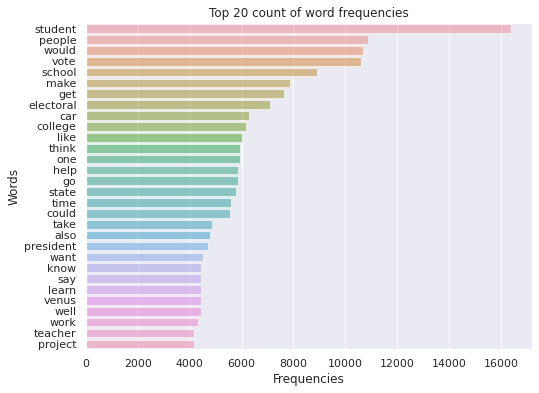

In [8]:
import seaborn as sns 
import matplotlib.pyplot as plt
top_words = freq_final.head(30).reset_index()

sns.reset_orig()
plt.figure(figsize = (8,6))
my_palette = sns.color_palette("colorblind") # variations of default palette: deep, muted, pastel, bright, dark, colorblind. 
plt.style.use('seaborn-colorblind')
sns.set(rc={'figure.figsize':(10,5)})
sns.barplot(x=top_words.iloc[:,1], y=top_words.iloc[:,0],data=top_words, alpha = 0.6).set_title('Top 20 count of word frequencies')
plt.xlabel('Frequencies')
plt.ylabel('Words')
plt.show()

#### Visualize the dataset to determine if data is normal distributed.

In [9]:
counts = df_train.discourse_effectiveness.value_counts()
print(counts)
print("\nPredicting only 0 = {:.2f}% accuracy".format(counts[0] / sum(counts) * 100))
print("\nPredicting only 1 = {:.2f}% accuracy".format(counts[1] / sum(counts) * 100))
print("\nPredicting only 2 = {:.2f}% accuracy".format(counts[2] / sum(counts) * 100))

Adequate       20977
Effective       9326
Ineffective     6462
Name: discourse_effectiveness, dtype: int64

Predicting only 0 = 57.06% accuracy

Predicting only 1 = 25.37% accuracy

Predicting only 2 = 17.58% accuracy


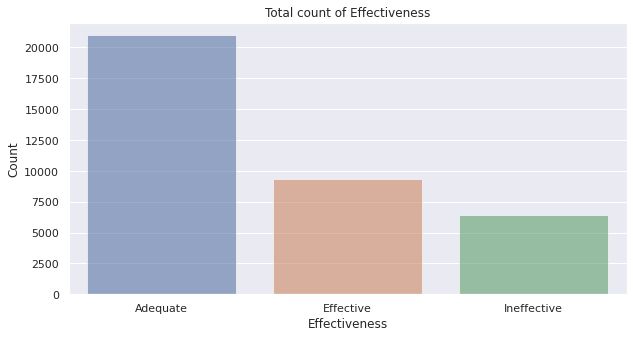

In [10]:
df_counts = pd.DataFrame(counts).reset_index()
plt.figure(figsize = (10,5))
sns.barplot(x=df_counts['index'],y=df_counts['discourse_effectiveness'],data=df_counts,alpha = 0.6).set_title('Total count of Effectiveness')
plt.xlabel('Effectiveness')
plt.ylabel('Count')
plt.show()

It can be observed that there are more Adequate feedbacks than Effective and Ineffective, indicating that the data may be imbalanced and may be prone to lower prediction accuracy. 

#### One-hot-encoding by creating dummies to categorical data.

In [11]:
df_effects = pd.get_dummies(df_train.iloc[:,4])
df_train = pd.concat([df_train, df_effects], axis=1) # combine dummy rows.

#### Train-test validation approach.

In [12]:
X_train, X_test, y_train, y_test = train_test_split(df_train['discourse_text'].values, df_train[['Adequate', 'Effective','Ineffective']].values, stratify=df_train['discourse_effectiveness'],test_size=0.1, random_state=100)

#### Tokenize most common words to prevent overftitting from noise text that least occur.

In [13]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
max_length = 30

tokenizer = Tokenizer(num_words= repeating_words, oov_token='x')
word_index = tokenizer.word_index
count_words = tokenizer.word_counts
tokenizer.fit_on_texts(X_train) 
tokenizer.fit_on_texts(X_test)
seq_train = tokenizer.texts_to_sequences(X_train)
seq_test = tokenizer.texts_to_sequences(X_test)
pad_train = pad_sequences(seq_train) 
pad_test = pad_sequences(seq_test)


pad_train.shape, pad_test.shape

((33088, 373), (3677, 259))

In [14]:
vocab_size = len(tokenizer.word_index)+1
print(vocab_size)

21752


#### Shuffle train set after splitting to improve or avoid overfitting and ensure data are representatives.


In [15]:
from sklearn.utils import shuffle
pad_train, y_train = shuffle(pad_train, y_train)
print(pad_train[9])

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0 

### Creating LST model to predict effectiveness of arguments.
Create LST model and add neuron layers to easily define relationship of the output classess. Last layer based on number of desired categorical/classes output of interest.

Linear regularization used in optimizer settings to prevent overfitting of data.

In [16]:
import tensorflow as tf
from tensorflow.keras import regularizers
import keras
from keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential 
import tensorflow
from tensorflow.keras.layers import Dropout


lst_mod = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=vocab_size, input_length = max_length, output_dim=32),
    tf.keras.layers.SpatialDropout1D(0.3),
    tf.keras.layers.LSTM(128, dropout = 0.4),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(3, activation='softmax')
])

from tensorflow.keras.losses import CategoricalCrossentropy
loss = CategoricalCrossentropy(from_logits = True)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
lst_mod.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])
lst_mod.summary()

2022-08-09 17:33:12.333327: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-09 17:33:12.455635: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-09 17:33:12.456555: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-09 17:33:12.458238: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 30, 32)            696064    
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 30, 32)            0         
_________________________________________________________________
lstm (LSTM)                  (None, 128)               82432     
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4

#### Implementing early stopper to prevent overfitting of data that may occur on validation accuracy.


In [17]:
class earlystop(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}): 
    if(logs.get('accuracy')>0.855):
      print("Accuracy has reached > 85.5%!") 
      self.model.stop_training = True
es = earlystop() 

After numerous trial runs, epochs = 20 provides constant increase in test accuracy. If epochs > 20, LST model may overfit, where train accuracy graduaually increasing while validation accuracy decreases.

##### Note:To run batches of data faster, it is recommended to turn on Accelerator to GPU under settings.

In [18]:
lst_mod1 = lst_mod.fit(pad_train, y_train, epochs=20, callbacks=[es],
            validation_data=(pad_test, y_test), verbose=1, batch_size=50)

2022-08-09 17:33:15.705327: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20


/opt/conda/lib/python3.7/site-packages/keras/backend.py:4847: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`categorical_crossentropy` received `from_logits=True`, but '
2022-08-09 17:33:18.397272: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


662/662 [==============================] - 20s 24ms/step - loss: 0.9135 - accuracy: 0.5980 - val_loss: 0.8248 - val_accuracy: 0.6356
Epoch 2/20
662/662 [==============================] - 16s 23ms/step - loss: 0.8245 - accuracy: 0.6427 - val_loss: 0.8185 - val_accuracy: 0.6405
Epoch 3/20
662/662 [==============================] - 15s 23ms/step - loss: 0.7945 - accuracy: 0.6525 - val_loss: 0.8078 - val_accuracy: 0.6432
Epoch 4/20
662/662 [==============================] - 15s 23ms/step - loss: 0.7709 - accuracy: 0.6610 - val_loss: 0.7978 - val_accuracy: 0.6397
Epoch 5/20
662/662 [==============================] - 15s 23ms/step - loss: 0.7515 - accuracy: 0.6690 - val_loss: 0.8026 - val_accuracy: 0.6437
Epoch 6/20
662/662 [==============================] - 16s 23ms/step - loss: 0.7256 - accuracy: 0.6798 - val_loss: 0.7895 - val_accuracy: 0.6462
Epoch 7/20
662/662 [==============================] - 15s 23ms/step - loss: 0.7101 - accuracy: 0.6904 - val_loss: 0.8122 - val_accuracy: 0.6416
Epo

#### Visualize overall accuracy and validation accuracy, as well as loss and validation loss of individual epochs of the LST model.

##### Note: Saving LST model into a variable allows the model to be visualized on graph, else it would return an error where history is not callable.

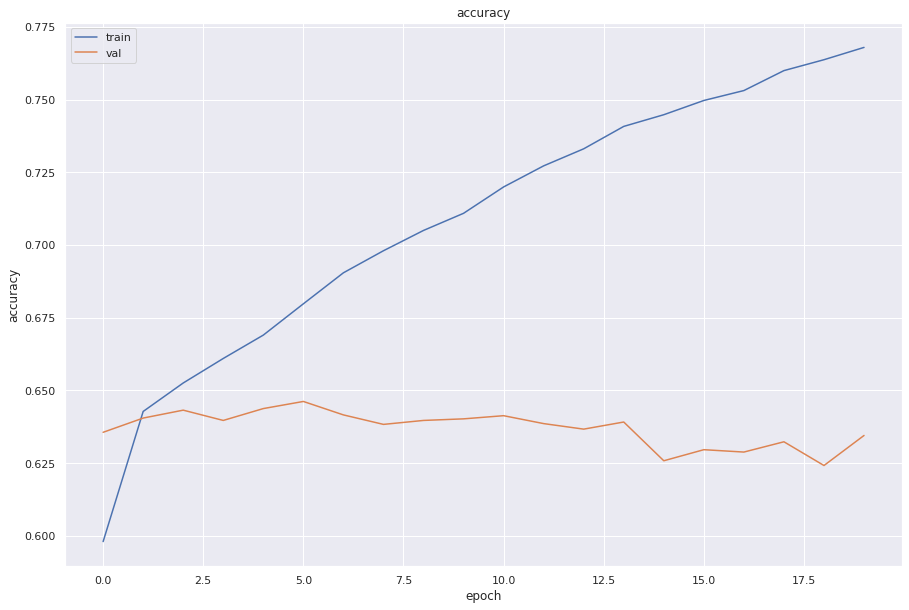

In [19]:
plt.figure(figsize = (15,10))
plt.plot(lst_mod1.history['accuracy'])
plt.plot(lst_mod1.history['val_accuracy'])
plt.title('accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

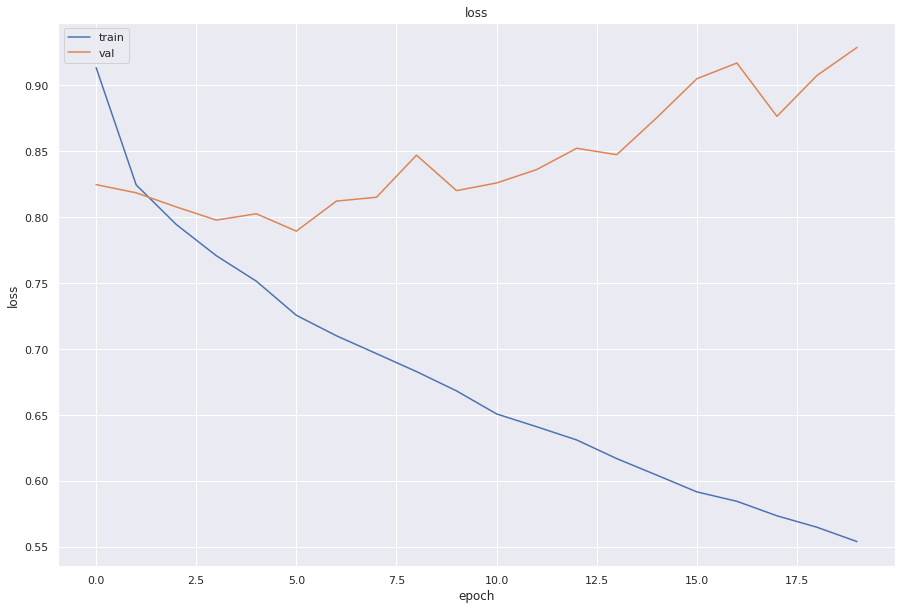

In [20]:
plt.figure(figsize = (15,10))
plt.plot(lst_mod1.history['loss'])
plt.plot(lst_mod1.history['val_loss'])
plt.title('loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

##### Predict LST model on padded test set from train-test split to determine the overall accuracy of the model before predicting on test.csv dataset.

In [21]:
y_predict = lst_mod.predict(pad_test, verbose=0)
print(y_predict)

[[0.25101042 0.7373019  0.01168773]
 [0.7340417  0.06194986 0.20400845]
 [0.6677384  0.299814   0.03244765]
 ...
 [0.8991293  0.03669031 0.06418037]
 [0.4094969  0.5672678  0.02323529]
 [0.6466057  0.24752033 0.105874  ]]


#### Confusion matrix

In [22]:
import sklearn.metrics as metrics
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
test_cm = metrics.confusion_matrix(y_test.argmax(axis=1), y_predict.argmax(axis=1))
print(test_cm)
test_score = metrics.accuracy_score(y_test.argmax(axis=1), y_predict.argmax(axis=1))
print(test_score)
test_report = metrics.classification_report(y_test.argmax(axis=1), y_predict.argmax(axis=1))
print(test_report)


[[1811  186  101]
 [ 507  416   10]
 [ 519   21  106]]
0.6344846342126734
              precision    recall  f1-score   support

           0       0.64      0.86      0.73      2098
           1       0.67      0.45      0.53       933
           2       0.49      0.16      0.25       646

    accuracy                           0.63      3677
   macro avg       0.60      0.49      0.50      3677
weighted avg       0.62      0.63      0.60      3677



It can be seen that basesd on classification report, 0: 'Adequate' has the highest overall accuracy in terms of precision (actual true positive ouf of predicted positive), recall (true positive rate) and f1-score (mean of precision and recall, taking consideration of false positive and false negatives)

It can also be observed that 'Adequate' has the highest number of observations supporting its accuracy.

Followed by 1:'Effective' with the second highest accuracy and 2: 'Ineffective' as the least overall accuracy. 


#### Visualize Confusion Matrix

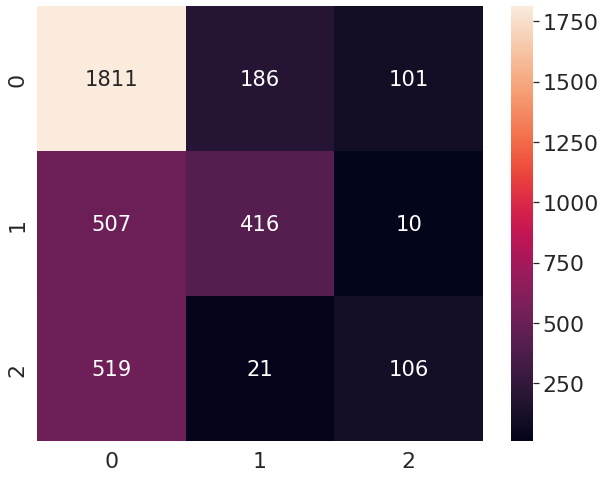

In [23]:
test_cm = pd.DataFrame(test_cm, range(3), range(3))
plt.figure(figsize = (10,8))
sns.set(font_scale=2)
sns.heatmap(test_cm, annot=True, annot_kws={"size": 21},fmt='d')
plt.show()

#### Similarly, data pre-process on test.csv dataset by removing stopwords, lemmatize and tokenize text into sequences of numbers for each letters and pad accordingly to faclitate prediction using above model on text in test.csv dataset

In [24]:
df_test['discourse_text'].replace("[^a-zA-Z]"," ", regex=True, inplace =True)  # match strings that contains non-letter and replace with black to remove string.punctuations.
df_test['discourse_text'] = df_test['discourse_text'].str.lower() # converts strings to lower case.
df_test['discourse_text'] = df_test['discourse_text'].apply(lambda x: [item for item in str(x).split() if item not in stop])
print(df_test['discourse_text'])

0    [making, choices, life, difficult, people, oft...
1    [seeking, multiple, opinions, help, person, ma...
2                           [decrease, stress, levels]
3               [great, chance, learn, something, new]
4                                [helpful, beneficial]
5    [making, decision, chance, become, stressed, o...
6    [everyone, different, may, experience, seeking...
7      [seeking, others, opinion, helpful, beneficial]
8    [taking, peoples, advice, say, may, lead, grea...
9    [learn, others, experiences, seeking, advice, ...
Name: discourse_text, dtype: object


In [25]:
word_test_index = tokenizer.word_index
count_test_words = tokenizer.word_counts
tokenizer.fit_on_texts(df_test.discourse_text)
seq_df_test = tokenizer.texts_to_sequences(df_test.discourse_text)
pad_df_test = pad_sequences(seq_df_test)


pad_df_test = shuffle(pad_df_test)
print(pad_df_test)

[[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0 4264 2821   59  431    3  325   64  100
   162   14   33  126   39   64  115  100 4264  128  164 5827  362    7
    92  128]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0 5180  115   78
   418  298]
 [   0    0    0    0    0 2821 7008  100   25   42  215  112  386  310
  5827  352   39  108   47   75   81  150  366   84  302    3   41  100
    24   75   51  120 2821  273 2821   81 9124   87  299 2821   42 2821
  2821   59]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
   418  298]
 [   0    0    0    0    0    0    0    0    0    0   26  115 2821 5180
   100   87 

In [26]:
y_test_predict = lst_mod.predict(pad_df_test, verbose=0)
print(y_test_predict)

[[7.85082579e-01 1.19432978e-01 9.54843760e-02]
 [6.01472199e-01 3.53178650e-01 4.53491397e-02]
 [7.57810533e-01 3.19612324e-02 2.10228175e-01]
 [4.87682939e-01 3.90206605e-01 1.22110404e-01]
 [9.56838965e-01 1.95682701e-02 2.35928129e-02]
 [6.90276623e-01 2.29653090e-01 8.00703093e-02]
 [7.88156807e-01 7.87605997e-03 2.03967184e-01]
 [7.62321591e-01 1.20659307e-01 1.17019184e-01]
 [7.56060958e-01 1.35037407e-01 1.08901635e-01]
 [7.29326531e-02 9.26464021e-01 6.03355933e-04]]


#### Round to nearest deciminal places,replace submissions dataset with test predictions on test.csv, and export as 'submission.csv' output.


In [27]:
df_test_predict = pd.DataFrame(y_test_predict, columns=['Adequate','Effective','Ineffective'])
final_test_dataset = pd.merge(df_test, df_test_predict, how = 'right', left_index= True ,right_index =True)
final_test_dataset = final_test_dataset[['discourse_id', 'Ineffective','Adequate', 'Effective',]]

final_test_dataset.reset_index()
decimals = 5    
final_test_dataset.iloc[:,1:4] = final_test_dataset.iloc[:,1:4].apply(lambda x: round(x, decimals))
print(final_test_dataset)


   discourse_id  Ineffective  Adequate  Effective
0  a261b6e14276      0.09548   0.78508    0.11943
1  5a88900e7dc1      0.04535   0.60147    0.35318
2  9790d835736b      0.21023   0.75781    0.03196
3  75ce6d68b67b      0.12211   0.48768    0.39021
4  93578d946723      0.02359   0.95684    0.01957
5  2e214524dbe3      0.08007   0.69028    0.22965
6  84812fc2ab9f      0.20397   0.78816    0.00788
7  c668ff840720      0.11702   0.76232    0.12066
8  739a6d00f44a      0.10890   0.75606    0.13504
9  bcfae2c9a244      0.00060   0.07293    0.92646
